# Nurvv samples - Unsupervised Learning
This notebook will attempt to understand Nurvv IMU samples, and if there's a way to classify step/no-step using an unsupervised method.

In [1]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
import numpy as np
import time

%matplotlib inline

# Extract IMU data

In [2]:
data_folder = '2019-07-23_CricketPitch_Grant' # Josh

In [3]:
df_acc = pd.read_csv(data_folder + '/imu_acc.csv') 
df_gyro = pd.read_csv(data_folder + '/imu_gyro.csv') 
df_gyro['Gyro-X'] = df_gyro['Gyro-X'].multiply(0.017453)
df_gyro['Gyro-Y'] = df_gyro['Gyro-Y'].multiply(0.017453)
df_gyro['Gyro-Z'] = df_gyro['Gyro-Z'].multiply(0.017453)
df_acc['Accel-X'] = df_acc['Accel-X'].multiply(9.80665)
df_acc['Accel-Y'] = df_acc['Accel-Y'].multiply(9.80665)
df_acc['Accel-Z'] = df_acc['Accel-Z'].multiply(9.80665)

#initial_timestamp = df_acc['TimeStamp'].values[0]
#final_timestamp = df_acc['TimeStamp'].values[-1]
initial_timestamp = 1_228_634_898
final_timestamp = 1_230_634_898

In [4]:
data_imu = [df_acc['TimeStamp'].values - df_acc['TimeStamp'].values[0],
            df_acc['Accel-X'].values, 
            df_acc['Accel-Y'].values, 
            df_acc['Accel-Z'].values, 
            df_gyro['Gyro-X'].values, 
            df_gyro['Gyro-Y'].values, 
            df_gyro['Gyro-Z'].values]

df_imu = pd.DataFrame(data_imu)
df_imu = df_imu.T
df_imu.columns = ['TimeStamp', 'Accel-X', 'Accel-Y', 'Accel-Z', 'Gyro-X', 'Gyro-Y', 'Gyro-Z']
df_imu=df_imu.set_index('TimeStamp')

# Attempt to use K-Means on IMU sensor samples

In [5]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(df_imu)

pd.DataFrame.from_records(kmeans.cluster_centers_, 
                          columns=['Accel-X', 'Accel-Y', 'Accel-Z', 'Gyro-X', 'Gyro-Y', 'Gyro-Z'])

,Accel-X,Accel-Y,Accel-Z,Gyro-X,Gyro-Y,Gyro-Z
0,48.146970,-64.678972,18.307942,0.867336,-0.484105,-0.942194
1,19.070502,2.575093,-1.347791,0.234267,-0.057575,0.134226


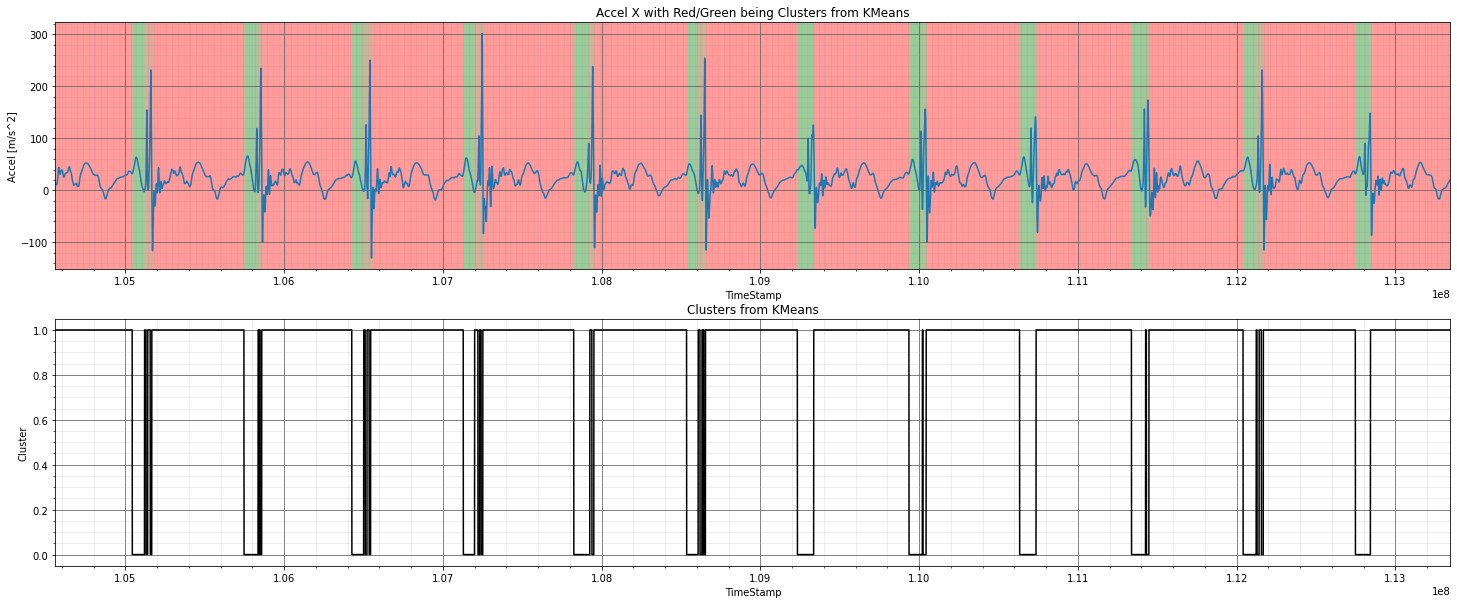

In [6]:
# Due to the amount of data we'll shorten the plotting to between these idx
idx_start = 119000
idx_end = 129000

plt.figure(figsize=(25,10))
plt.subplot(211)
plt.title(f"Accel X with Red/Green being Clusters from KMeans")
plt.ylabel('Accel [m/s^2]')
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.minorticks_on()
plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.xlabel('TimeStamp')
plt.plot(df_imu.index[idx_start:idx_end], df_imu['Accel-X'].values[idx_start:idx_end])
colors = ['green', 'red', 'tab:orange', 'tab:blue']
for idx,lbl in enumerate(kmeans.labels_[idx_start+1:idx_end]):
    plt.gca().axvspan(df_imu.index[idx_start+idx+1], df_imu.index[idx_start+idx], alpha=0.05, color=colors[lbl])
plt.xlim([df_imu.index[idx_start], df_imu.index[idx_end]])
        
plt.subplot(212)
plt.title(f"Clusters from KMeans")
plt.ylabel('Cluster')
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.minorticks_on()
plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.xlabel('TimeStamp')
plt.plot(df_imu.index[idx_start:idx_end], kmeans.labels_[idx_start:idx_end], c='k')
plt.xlim([df_imu.index[idx_start], df_imu.index[idx_end]])

plt.show()

In order to improve on these results we are going to apply a rolling average and round it up if value is above 0.5:
- This will make it so that we avoid step/no-step oscillatory behaviour
- Delay the step detection to be more inline with actual footstrike

In [7]:
# Select our expected output to be the one given by Kmeans
df_imu['FSD'] = kmeans.labels_

WINDOW_AVERAGE = 85
df_imu['FSD'] = df_imu['FSD'].rolling(window=WINDOW_AVERAGE, min_periods=1).mean().round()

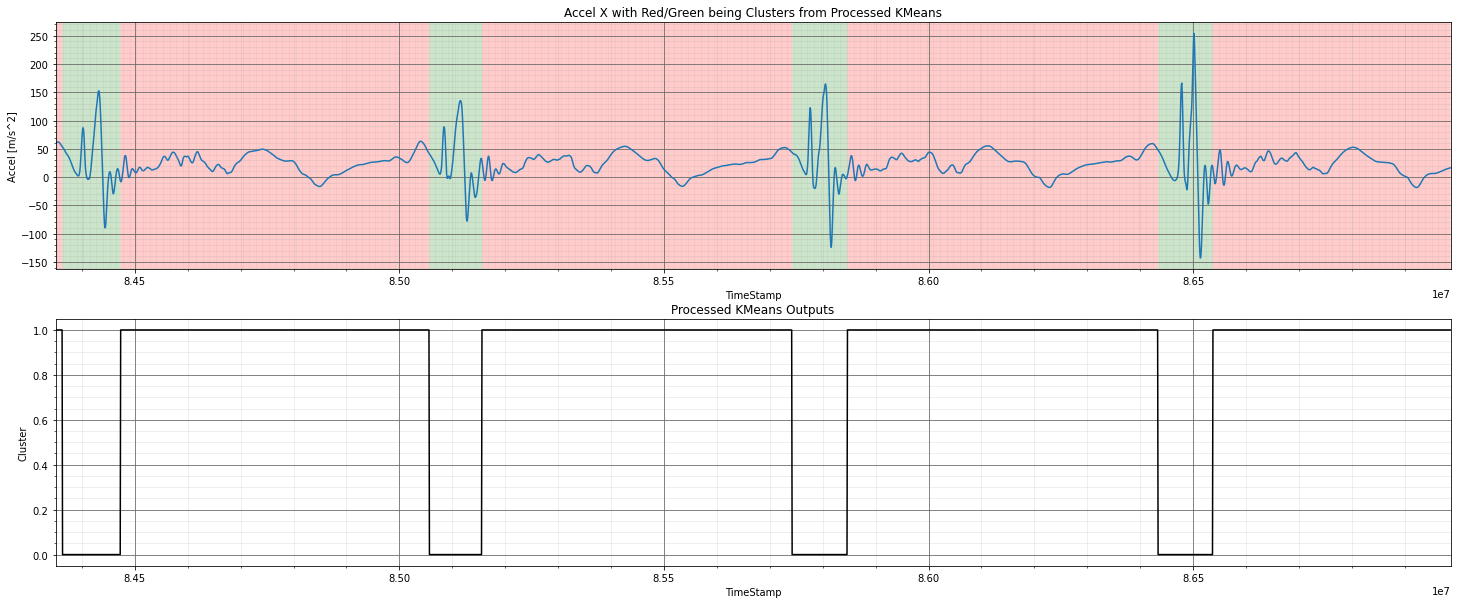

In [8]:
# Due to the amount of data we'll shorten the plotting to between these idx
idx_start = 96000
idx_end = 99000

plt.figure(figsize=(25,10))
plt.subplot(211)
plt.title(f"Accel X with Red/Green being Clusters from Processed KMeans")
plt.ylabel('Accel [m/s^2]')
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.minorticks_on()
plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.xlabel('TimeStamp')
plt.plot(df_imu.index[idx_start:idx_end], df_imu['Accel-X'].values[idx_start:idx_end])
colors = ['green', 'red', 'tab:orange', 'tab:blue']
for idx,lbl in enumerate(df_imu['FSD'].values[idx_start+1:idx_end]):
    plt.gca().axvspan(df_imu.index[idx_start+idx+1], df_imu.index[idx_start+idx], alpha=0.05, color=colors[int(lbl)])
plt.xlim([df_imu.index[idx_start], df_imu.index[idx_end]])


plt.subplot(212)
plt.title(f"Processed KMeans Outputs")
plt.ylabel('Cluster')
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.minorticks_on()
plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.xlabel('TimeStamp')
plt.plot(df_imu.index[idx_start:idx_end], df_imu['FSD'].values[idx_start:idx_end], c='k')
plt.xlim([df_imu.index[idx_start], df_imu.index[idx_end]])

plt.show()

In [9]:
# As seen above the FSD instances are quite large, and it appears they are too large
# and contain areas that do not correspond to feet on the floor. Hence, we apply
# a convolution which will "narrow down" these. By trial-error, 50 seemed to do the job
N = 50
df_imu['FSD'] = np.convolve(df_imu['FSD'].values, np.ones(N)/N, mode='same')
df_imu['FSD'] = df_imu['FSD'].apply(lambda x: 1 if x>0.95 else 0)

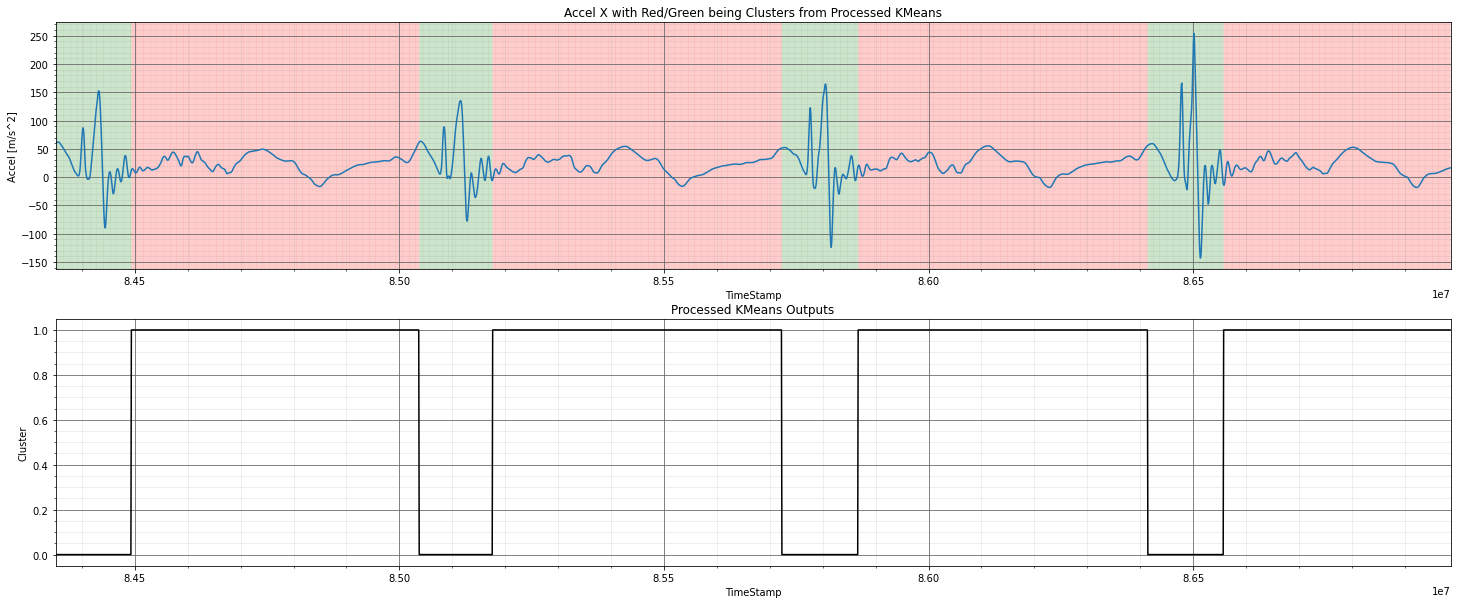

In [10]:
# Due to the amount of data we'll shorten the plotting to between these idx
offset = 0
idx_start = 96000 + offset
idx_end = 99000 + offset

plt.figure(figsize=(25,10))

plt.subplot(211)
plt.title(f"Accel X with Red/Green being Clusters from Processed KMeans")
plt.ylabel('Accel [m/s^2]')
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.minorticks_on()
plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.xlabel('TimeStamp')
plt.plot(df_imu.index[idx_start:idx_end], df_imu['Accel-X'].values[idx_start:idx_end])
colors = ['green', 'red', 'tab:orange', 'tab:blue']
for idx,lbl in enumerate(df_imu['FSD'].values[idx_start+1:idx_end]):
    plt.gca().axvspan(df_imu.index[idx_start+idx+1], df_imu.index[idx_start+idx], alpha=0.05, color=colors[int(lbl)])
plt.xlim([df_imu.index[idx_start], df_imu.index[idx_end]])


plt.subplot(212)
plt.title(f"Processed KMeans Outputs")
plt.ylabel('Cluster')
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.minorticks_on()
plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.xlabel('TimeStamp')
plt.plot(df_imu.index[idx_start:idx_end], df_imu['FSD'].values[idx_start:idx_end], c='k')
plt.xlim([df_imu.index[idx_start], df_imu.index[idx_end]])

plt.show()

https://www.thekerneltrip.com/machine/learning/computational-complexity-learning-algorithms/

# SVM on labelled data from K-Means
https://cs.stanford.edu/~karpathy/svmjs/demo/demoforest.html

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import seaborn as sn
from sklearn.metrics import classification_report, confusion_matrix

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    df_imu[['Accel-X', 'Accel-Y', 'Accel-Z', 'Gyro-X', 'Gyro-Y', 'Gyro-Z']], 
    df_imu['FSD'], 
    test_size = 0.20)

# This algorithm doesn't has any time dependence, so it doesn't matter the train/test split
# however, we need to sort these for visualization purposes

In [13]:
svclassifier = SVC(kernel='rbf')
classify = svclassifier.fit(X_train, y_train)

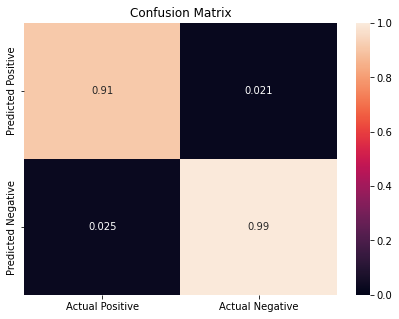

In [14]:
y_pred = svclassifier.predict(X_test)
C = confusion_matrix(y_test, y_pred)

df_cm = pd.DataFrame(C / C.astype(np.float).sum(axis=1), 
                     index = ['Predicted Positive', 'Predicted Negative'],
                     columns = ['Actual Positive', 'Actual Negative'])
plt.figure(figsize = (7,5))
plt.title('Confusion Matrix')
sn.heatmap(df_cm, vmin=0, vmax=1, annot=True)
plt.show()

In [15]:
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nScores:")
print(classification_report(y_test, y_pred))

Confusion Matrix:
[[ 8816   908]
 [  243 42703]]

Scores:
              precision    recall  f1-score   support

           0       0.97      0.91      0.94      9724
           1       0.98      0.99      0.99     42946

    accuracy                           0.98     52670
   macro avg       0.98      0.95      0.96     52670
weighted avg       0.98      0.98      0.98     52670



In [16]:
# Order these samples that have not been seen before by algorithm
X_test_sorted = X_test.sort_index()
y_test_sorted = y_test.sort_index()

y_pred_sorted = pd.Series(y_pred, X_test.index).sort_index()

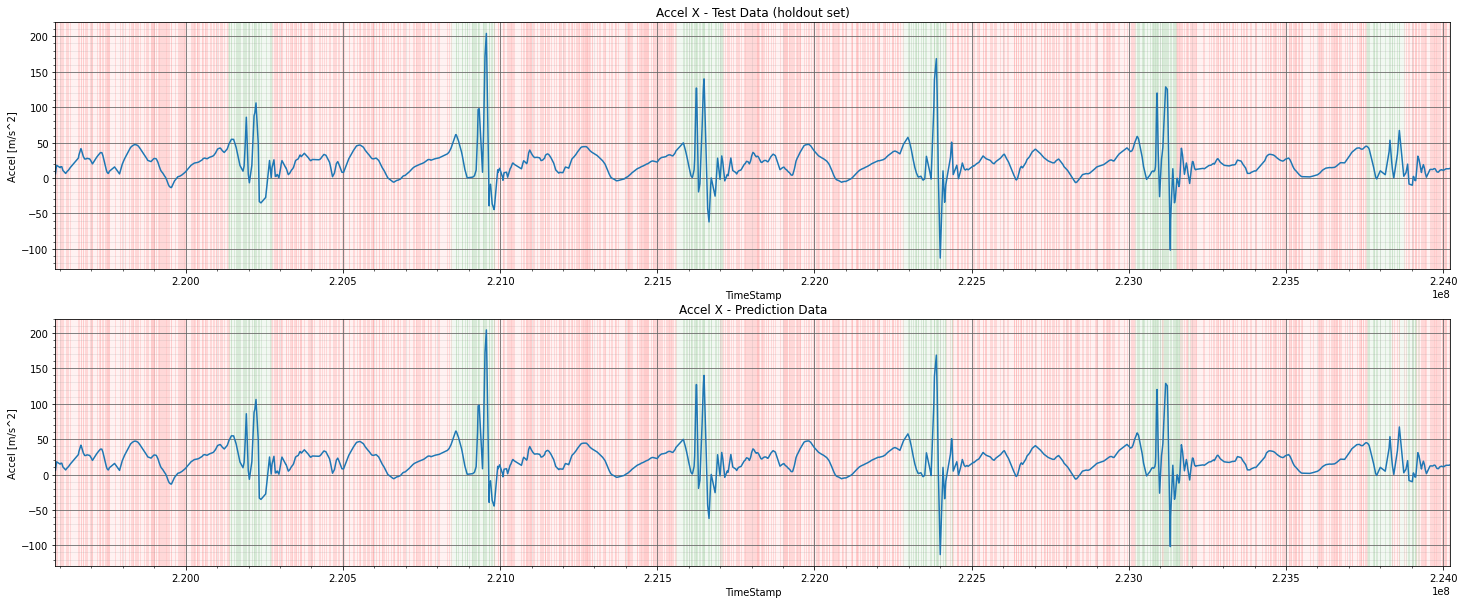

In [17]:
idx_start = 50000
idx_end = 51000

plt.figure(figsize=(25,10))

plt.subplot(211)
plt.title(f"Accel X - Test Data (holdout set)")
plt.ylabel('Accel [m/s^2]')
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.minorticks_on()
plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.xlabel('TimeStamp')
plt.plot(X_test_sorted.index[idx_start:idx_end], X_test_sorted['Accel-X'].values[idx_start:idx_end])
colors = ['green', 'red', 'tab:orange', 'tab:blue']
for idx,lbl in enumerate(y_test_sorted.values[idx_start+1:idx_end]):
    plt.gca().axvspan(X_test_sorted.index[idx_start+idx+1], X_test_sorted.index[idx_start+idx], alpha=0.05, color=colors[int(lbl)])
plt.xlim([X_test_sorted.index[idx_start], X_test_sorted.index[idx_end]])


plt.subplot(212)
plt.title(f"Accel X - Prediction Data")
plt.ylabel('Accel [m/s^2]')
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.minorticks_on()
plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.xlabel('TimeStamp')
plt.plot(X_test_sorted.index[idx_start:idx_end], X_test_sorted['Accel-X'].values[idx_start:idx_end])
colors = ['green', 'red', 'tab:orange', 'tab:blue']
for idx,lbl in enumerate(y_pred_sorted.values[idx_start+1:idx_end]):
    plt.gca().axvspan(X_test_sorted.index[idx_start+idx+1], X_test_sorted.index[idx_start+idx], alpha=0.05, color=colors[int(lbl)])
plt.xlim([X_test_sorted.index[idx_start], X_test_sorted.index[idx_end]])

plt.show()

initial decision function shape;  (4524806,)
after reshape:  (1859, 2434)


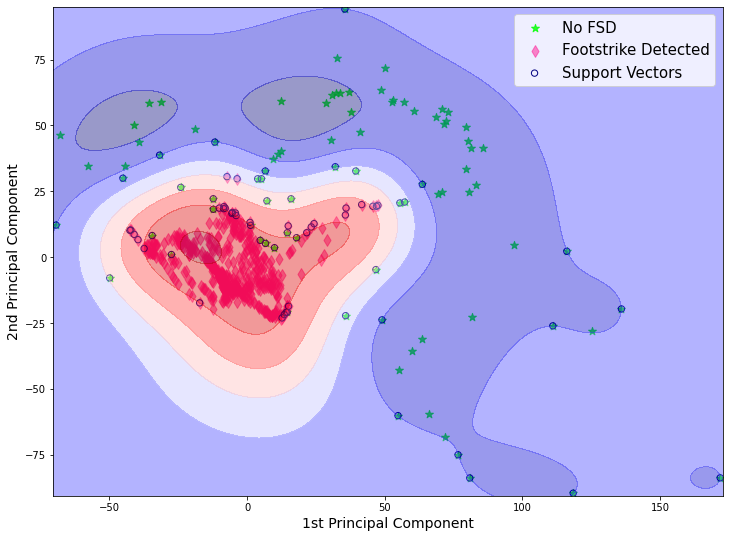

In [18]:
initial_timestamp = 50_000
final_timestamp = 50_600
pca2 = PCA(n_components=2)
X_test_reduced = pca2.fit_transform(X_test_sorted.values[initial_timestamp:final_timestamp])

svm_model = SVC(kernel='rbf')
classify = svm_model.fit(X_test_reduced, pd.Series(y_test, X_test.index).sort_index().values[initial_timestamp:final_timestamp])

def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    print ('initial decision function shape; ', np.shape(Z))
    Z = Z.reshape(xx.shape)
    print ('after reshape: ', np.shape(Z))
    out = ax.contourf(xx, yy, Z, **params)
    return out

def make_meshgrid(x, y, h=.1):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h).astype(np.float32),
                         np.arange(y_min, y_max, h).astype(np.float32))
    return xx, yy

X0, X1 = X_test_reduced[:, 0], X_test_reduced[:, 1]
xx, yy = make_meshgrid(X0, X1)

fig, ax = plt.subplots(figsize=(12,9))
fig.patch.set_facecolor('white')
cdict1={0:'lime',1:'deeppink'}

Y_tar_list = pd.Series(y_test, X_test.index).sort_index().values[initial_timestamp:final_timestamp]
yl1= [int(target1) for target1 in Y_tar_list]
labels1=yl1
 
labl1={1:'Footstrike Detected',0:'No FSD'}
marker1={0:'*',1:'d'}
alpha1={0:.8, 1:0.5}

for l1 in np.unique(labels1):
    ix1=np.where(labels1==l1)
    ax.scatter(X0[ix1],X1[ix1], c=cdict1[l1],label=labl1[l1],s=70,marker=marker1[l1],alpha=alpha1[l1])

ax.scatter(svm_model.support_vectors_[:, 0], svm_model.support_vectors_[:, 1], s=40, facecolors='none', 
           edgecolors='navy', label='Support Vectors')

plot_contours(ax, classify, xx, yy,cmap='seismic', alpha=0.4)
plt.legend(fontsize=15)

plt.xlabel("1st Principal Component",fontsize=14)
plt.ylabel("2nd Principal Component",fontsize=14)

plt.show()